# Course 5 End-of-course project: Build a multiple linear regression model

In this activity, you will build a multiple linear regression model
<br/>

**The purpose** of this project is to demostrate knowledge of EDA and a multiple linear regression model

**The goal** is to build a multiple linear regression model and evaluate the model

# The goal - predict trip duration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv("Transformed_2017_Yellow_Taxi_Trip_Data.csv") 

In [3]:
df.dtypes

Unnamed: 0.1               int64
Unnamed: 0                 int64
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
Trip_duration             object
dtype: object

Variables, which probably can affect on trip duration:
* VendorID
* Passenger_count
* PULocationID
* DOLocationID
* RateCodeID
* Payment_type
* Improvement_surcharge
* Tip_amount
* Extra

all the variables are not continues exept one - tip amount

I do not include the trip distance, because these two variables correlates a lot but there is no customer story that can increase one variable and not to increase another.

## Identify correlations

* Preparation

In [4]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['Trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [5]:
df['Trip_duration_in_seconds'] = df['Trip_duration'].apply(lambda x: x.total_seconds())
df['Trip_duration_in_seconds']

0         844.0
1        1590.0
2         432.0
3        1815.0
4        1003.0
          ...  
22654     196.0
22655    2448.0
22656     248.0
22657     716.0
22658     800.0
Name: Trip_duration_in_seconds, Length: 22659, dtype: float64

In [6]:
q25 = df['Trip_duration_in_seconds'].quantile(0.25)
q75 = df['Trip_duration_in_seconds'].quantile(0.75)

lower_bound = q25 - (q75 - q25)*1.5
upper_bound = q75 + (q75 - q25)*1.5

In [7]:
sub_df = df.loc[(df['Trip_duration_in_seconds']>=lower_bound)&(df['Trip_duration_in_seconds']<=upper_bound)]

* VendorID

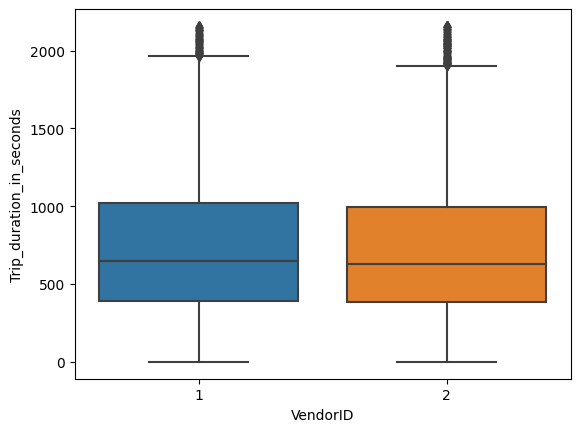

In [8]:
sns.boxplot(x=sub_df['VendorID'], y=sub_df['Trip_duration_in_seconds']);

without outliers:

In [9]:
print(sub_df.loc[sub_df['VendorID']==1]['Trip_duration_in_seconds'].mean(), 
      sub_df.loc[sub_df['VendorID']==2]['Trip_duration_in_seconds'].mean())

750.6644957983193 738.2155924806982


In [10]:
print(sub_df.loc[sub_df['VendorID']==1]['Trip_duration_in_seconds'].median(), 
      sub_df.loc[sub_df['VendorID']==2]['Trip_duration_in_seconds'].median())

648.5 632.0


almost no difference 

* Passenger count

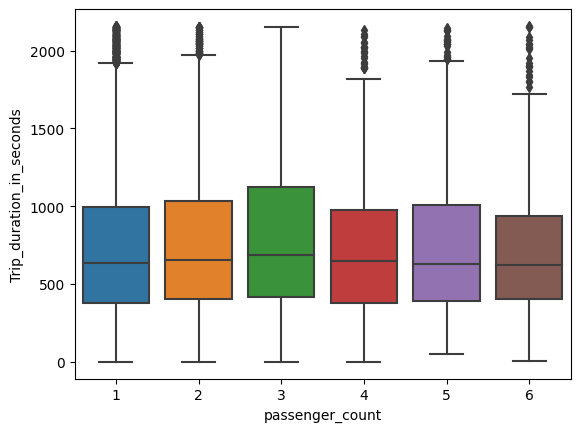

In [11]:
sns.boxplot(x=sub_df['passenger_count'], y=sub_df['Trip_duration_in_seconds']);

In [12]:
print(sub_df.loc[sub_df['passenger_count']==1]['Trip_duration_in_seconds'].mean()) 
print(sub_df.loc[sub_df['passenger_count']==2]['Trip_duration_in_seconds'].mean()) 
print(sub_df.loc[sub_df['passenger_count']==3]['Trip_duration_in_seconds'].mean()) 
print(sub_df.loc[sub_df['passenger_count']==4]['Trip_duration_in_seconds'].mean()) 
print(sub_df.loc[sub_df['passenger_count']==5]['Trip_duration_in_seconds'].mean()) 
print(sub_df.loc[sub_df['passenger_count']==6]['Trip_duration_in_seconds'].mean()) 

737.0321293024473
761.0849757673667
802.1190738699007
763.0189125295508
743.7404651162791
725.1070336391438


It worth to include in the model

* PULocationID

In [13]:
Value_list = []
PULID_min = 0
PULID_max = 0

for u in sub_df['PULocationID'].unique():
    value = sub_df.loc[sub_df['PULocationID']==u]['Trip_duration_in_seconds'].mean()
    Value_list.append(value)
    
    if PULID_min == 0:
        PULID_min = value
        PULID_max = value
    
    elif PULID_min > value:
        PULID_min = value
    
    elif PULID_max < value:
        PULID_max = value

print(PULID_min, PULID_max)

2.0 2077.0


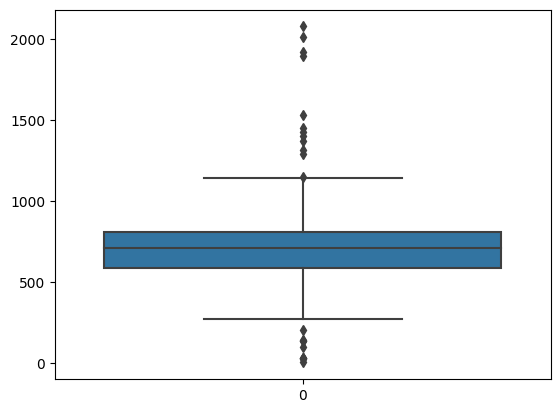

In [14]:
sns.boxplot(Value_list);

It worth to include in the model

* DOLocationID

In [15]:
Value_list = []
DOLID_min = 0
DOLID_max = 0

for u in sub_df['DOLocationID'].unique():
    value = sub_df.loc[sub_df['DOLocationID']==u]['Trip_duration_in_seconds'].mean()
    Value_list.append(value)
    
    if DOLID_min == 0:
        DOLID_min = value
        DOLID_max = value
    
    elif DOLID_min > value:
        DOLID_min = value
    
    elif DOLID_max < value:
        DOLID_max = value

print(DOLID_min, DOLID_max)

255.0 2151.0


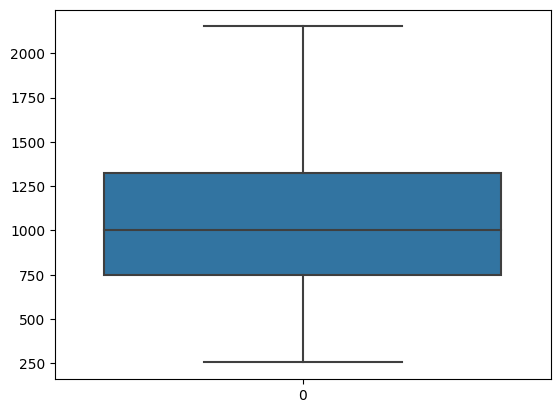

In [16]:
sns.boxplot(Value_list);

It worth to include in the model

* RateCodeID

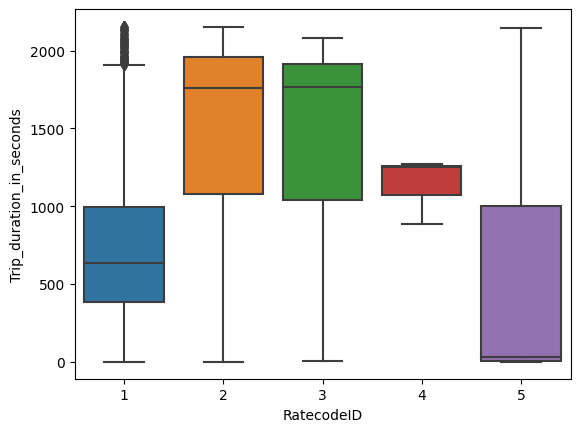

In [17]:
sns.boxplot(x=sub_df['RatecodeID'], y=sub_df['Trip_duration_in_seconds']);

It worth to include in the model

* Payment type

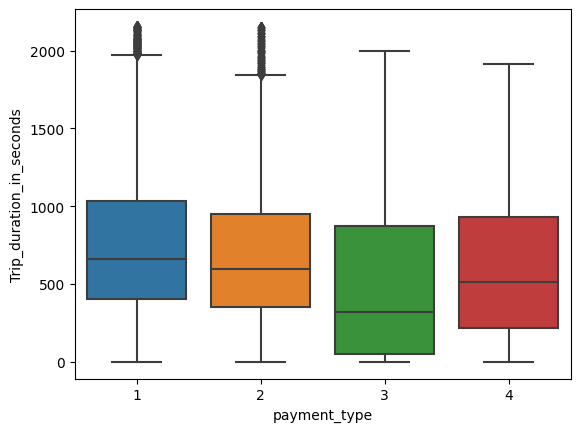

In [18]:
sns.boxplot(x=sub_df['payment_type'], y=sub_df['Trip_duration_in_seconds']);

It worth to include in the model

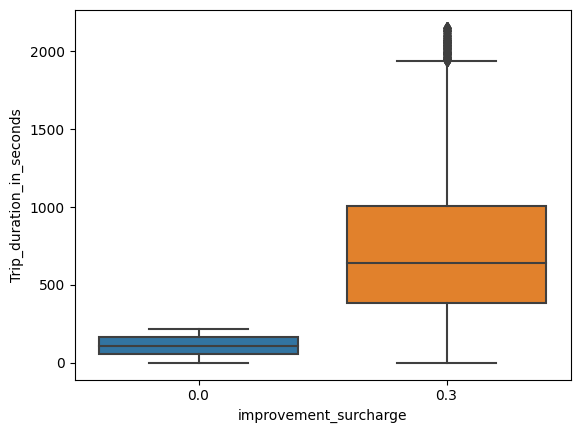

In [19]:
sns.boxplot(x=sub_df['improvement_surcharge'], y=sub_df['Trip_duration_in_seconds']);

It worth to include in the model

* Tip amount

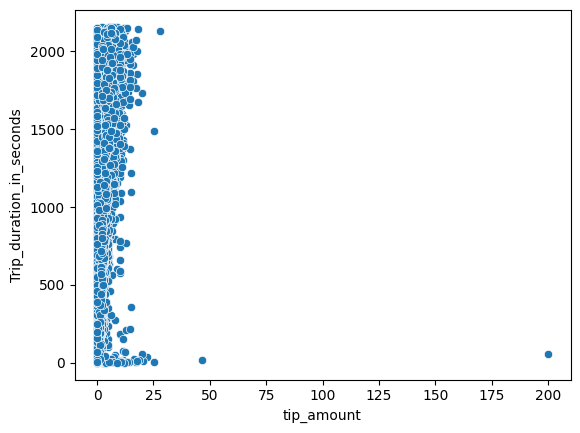

In [20]:
sns.scatterplot(x=sub_df['tip_amount'], y=sub_df['Trip_duration_in_seconds']);

let's exclude the obvious outlier

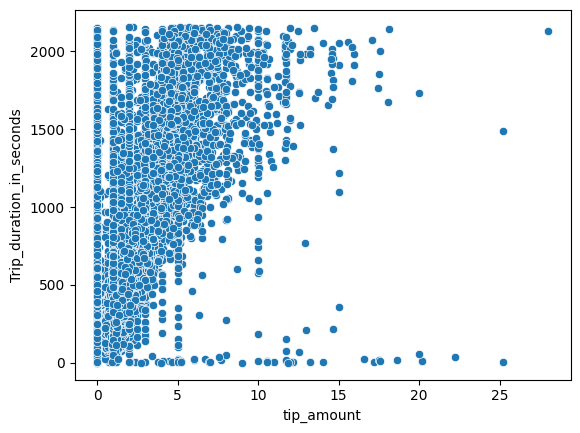

In [21]:
sns.scatterplot(x=sub_df.loc[sub_df['tip_amount'] < 30]['tip_amount'], 
                y=sub_df.loc[sub_df['tip_amount'] < 30]['Trip_duration_in_seconds']);

In [22]:
matrix = sub_df[['tip_amount', 'Trip_duration_in_seconds']].corr()
print(matrix)

                          tip_amount  Trip_duration_in_seconds
tip_amount                  1.000000                  0.344578
Trip_duration_in_seconds    0.344578                  1.000000


it worth to make a hypothesis test

* Extra

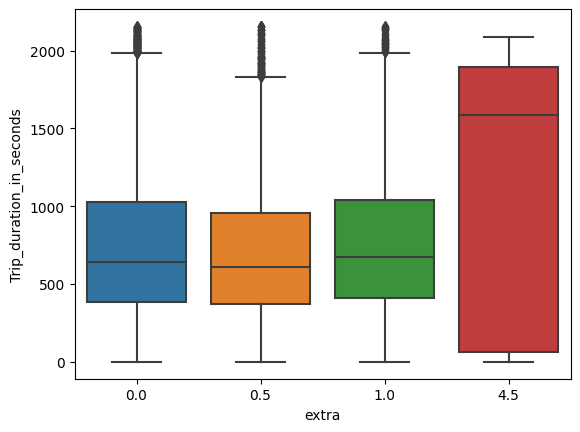

In [23]:
sns.boxplot(x=sub_df['extra'], y=sub_df['Trip_duration_in_seconds']);

It worth to include in the model

Variablesto include in the model:

* Passenger_count
* PULocationID
* DOLocationID
* RateCodeID
* Payment_type
* Improvement_surcharge
* Tip_amount
* Extra

Set your Y and X variables. Y represents the outcome variable, and X represents the features.

In [24]:
X = sub_df[['passenger_count','PULocationID','DOLocationID','RatecodeID',
            'payment_type','improvement_surcharge','tip_amount','extra']]
y = sub_df[['Trip_duration_in_seconds']]

Create training and testing sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Build and fit your model to the data.

In [26]:
formula = 'Trip_duration_in_seconds ~ C(passenger_count) + C(PULocationID) + C(DOLocationID) + C(RatecodeID)+ C(payment_type) + C(improvement_surcharge) + tip_amount + C(extra)'

ols_data = pd.concat([X_train, y_train], axis = 1)

OLS = ols(formula=formula, data=ols_data)

In [27]:
model = OLS.fit()

Evaluate your model performance by calculating the residual sum of squares and the explained variance score (R^2). Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error.

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Trip_duration_in_seconds   R-squared:                       0.354
Model:                                  OLS   Adj. R-squared:                  0.339
Method:                       Least Squares   F-statistic:                     23.36
Date:                      Tue, 16 May 2023   Prob (F-statistic):               0.00
Time:                              08:17:01   Log-Likelihood:            -1.1023e+05
No. Observations:                     15005   AIC:                         2.212e+05
Df Residuals:                         14660   BIC:                         2.238e+05
Df Model:                               344                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1120.0926    388.402      2.884      0.004     358.775    1881.410
C(passenger_count)[T.2]    10.5134      9.019      1.166      0.244      -7.166      28.193
C(passenger_count)[T.3]    46.8598     15.673      2.990      0.003      16.140      77.580
C(passenger_count)[T.4]    63.0696     22.776      2.769      0.006      18.426     107.713
C(passenger_count)[T.5]     9.2499     14.587      0.634      0.526     -19.342      37.841
C(passenger_count)[T.6]   -17.5650     18.039     -0.974      0.330     -52.924      17.794
C(PULocationID)[T.4]     -411.7115    452.466     -0.910      0.363   -1298.601     475.178
C(PULocationID)[T.7]     -542.8359    456.192     -1.190      0.234   -1437.029     351.357
C(PULocationID)[T.12]     362.0628    480.250      0.754      0.451    -579.287    1303.413
C(PULocationID)[T.13]    -265.3664    450.185     -0.589      0.556   -1147.786     617.053
C(PULocationID)[T.14]   -1501.9185    599.927     -2.504      0.012   -2677.850    -325.987
C(PULocationID)[T.17]    -441.0549    506.807     -0.870      0.384   -1434.461     552.351
C(PULocationID)[T.24]    -438.9379    452.988     -0.969      0.333   -1326.851     448.975
C(PULocationID)[T.25]    -554.6008    457.462     -1.212      0.225   -1451.285     342.083
C(PULocationID)[T.28]   -1389.0667    525.558     -2.643      0.008   -2419.227    -358.906
C(PULocationID)[T.29]   -1363.4899    648.143     -2.104      0.035   -2633.931     -93.049
C(PULocationID)[T.31]     123.9683    589.122      0.210      0.833   -1030.785    1278.721
C(PULocationID)[T.33]    -344.4927    461.243     -0.747      0.455   -1248.587     559.602
C(PULocationID)[T.35]    -300.1608    595.644     -0.504      0.614   -1467.698     867.377
C(PULocationID)[T.36]    -668.5165    510.997     -1.308      0.191   -1670.136     333.103
C(PULocationID)[T.37]    -151.1622    492.334     -0.307      0.759   -1116.199     813.875
C(PULocationID)[T.40]    -630.5540    464.150     -1.359      0.174   -1540.346     279.238
C(PULocationID)[T.41]    -393.3767    451.770     -0.871      0.384   -1278.902     492.149
C(PULocationID)[T.42]    -638.8844    455.713     -1.402      0.161   -1532.139     254.370
C(PULocationID)[T.43]    -341.3452    449.900     -0.759      0.448   -1223.206     540.515
C(PULocationID)[T.45]    -388.0137    453.425     -0.856      0.392   -1276.784     500.756
C(PULocationID)[T.46]    -489.8270    271.657     -1.803      0.071   -1022.308      42.654
C(PULocationID)[T.48]    -387.4057    449.518     -0.862      0.389   -1268.518     493.707
C(PULocationID)[T.49]    -731.9356    474.986     -1.541      0.123   -1662.969     199.098
C(PULocationID)[T.50]    -432.2320    450.116     -0.960      0.337   -13

The model needs to be optimised